## NN Adv Assignment

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [108]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [109]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [110]:
train['label'].nunique()

10

In [55]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [111]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [112]:
X_test = test.values

In [113]:
X_test.shape

(10500, 784)

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [115]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [116]:
BATCH_SIZE = 128
EPOCHS = 15


from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [117]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [118]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [119]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [120]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## baseline_pytorch

In [65]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [66]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [67]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.3142, 	Train Accuracy: 56.56 %, 	Val Loss: 0.8089, 	Val Accuracy: 71.28 % 

[EPOCH: 2], 	Train Loss: 0.7097, 	Train Accuracy: 74.62 %, 	Val Loss: 0.6382, 	Val Accuracy: 76.64 % 

[EPOCH: 3], 	Train Loss: 0.6056, 	Train Accuracy: 78.49 %, 	Val Loss: 0.5651, 	Val Accuracy: 80.35 % 

[EPOCH: 4], 	Train Loss: 0.5537, 	Train Accuracy: 80.66 %, 	Val Loss: 0.5330, 	Val Accuracy: 80.87 % 

[EPOCH: 5], 	Train Loss: 0.5201, 	Train Accuracy: 81.73 %, 	Val Loss: 0.5056, 	Val Accuracy: 81.77 % 

[EPOCH: 6], 	Train Loss: 0.4986, 	Train Accuracy: 82.48 %, 	Val Loss: 0.4824, 	Val Accuracy: 82.97 % 

[EPOCH: 7], 	Train Loss: 0.4834, 	Train Accuracy: 82.99 %, 	Val Loss: 0.4747, 	Val Accuracy: 83.13 % 

[EPOCH: 8], 	Train Loss: 0.4705, 	Train Accuracy: 83.57 %, 	Val Loss: 0.4597, 	Val Accuracy: 83.59 % 

[EPOCH: 9], 	Train Loss: 0.4609, 	Train Accuracy: 83.73 %, 	Val Loss: 0.4551, 	Val Accuracy: 83.87 % 

[EPOCH: 10], 	Train Loss: 0.4536, 	Train Accuracy: 84.22 %, 	Val Loss: 0.

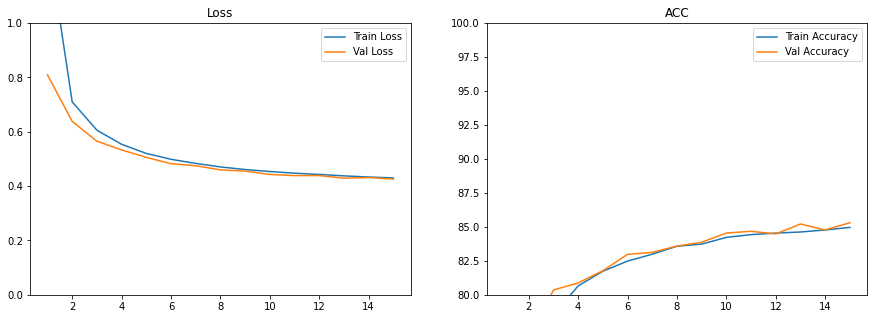

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 변형해보기

In [122]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = F.relu(self.linear1(x))
    x =  F.relu(self.linear2(x))
    x =  F.relu(self.linear3(x))
    x =  F.relu(self.linear4(x))
    return x

In [123]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [124]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 2.1948, 	Train Accuracy: 33.03 %, 	Val Loss: 1.8612, 	Val Accuracy: 38.52 % 

[EPOCH: 2], 	Train Loss: 1.4707, 	Train Accuracy: 52.89 %, 	Val Loss: 1.1307, 	Val Accuracy: 66.04 % 

[EPOCH: 3], 	Train Loss: 0.9793, 	Train Accuracy: 69.61 %, 	Val Loss: 0.8881, 	Val Accuracy: 72.27 % 

[EPOCH: 4], 	Train Loss: 0.8435, 	Train Accuracy: 73.37 %, 	Val Loss: 0.7974, 	Val Accuracy: 74.50 % 

[EPOCH: 5], 	Train Loss: 0.7814, 	Train Accuracy: 74.69 %, 	Val Loss: 0.7802, 	Val Accuracy: 74.33 % 

[EPOCH: 6], 	Train Loss: 0.7445, 	Train Accuracy: 75.50 %, 	Val Loss: 0.7249, 	Val Accuracy: 75.82 % 

[EPOCH: 7], 	Train Loss: 0.7169, 	Train Accuracy: 76.15 %, 	Val Loss: 0.6972, 	Val Accuracy: 76.76 % 

[EPOCH: 8], 	Train Loss: 0.6980, 	Train Accuracy: 76.61 %, 	Val Loss: 0.6816, 	Val Accuracy: 77.07 % 

[EPOCH: 9], 	Train Loss: 0.6818, 	Train Accuracy: 77.15 %, 	Val Loss: 0.6712, 	Val Accuracy: 77.47 % 

[EPOCH: 10], 	Train Loss: 0.6682, 	Train Accuracy: 77.51 %, 	Val Loss: 0.

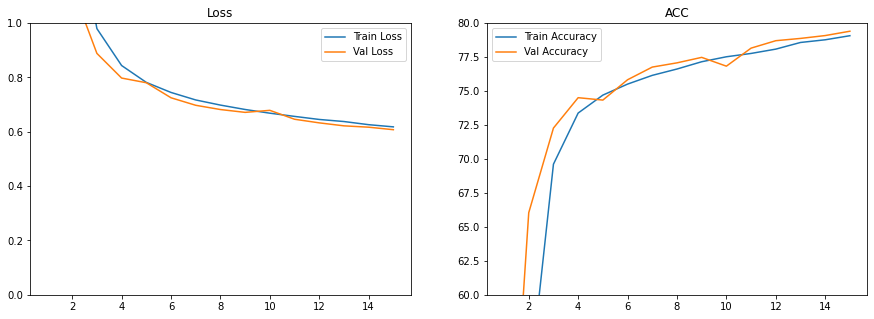

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(60, 80)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

각 층마다 output에 대해 relu를 적용해줬지만 성능이 더 안 좋아졌다

## 변형하기 2

### Weight Initialization

In [151]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [152]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [153]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.9782, 	Train Accuracy: 68.83 %, 	Val Loss: 0.6328, 	Val Accuracy: 77.76 % 

[EPOCH: 2], 	Train Loss: 0.5684, 	Train Accuracy: 80.29 %, 	Val Loss: 0.5179, 	Val Accuracy: 81.76 % 

[EPOCH: 3], 	Train Loss: 0.5028, 	Train Accuracy: 82.28 %, 	Val Loss: 0.4682, 	Val Accuracy: 83.70 % 

[EPOCH: 4], 	Train Loss: 0.4688, 	Train Accuracy: 83.48 %, 	Val Loss: 0.4433, 	Val Accuracy: 84.37 % 

[EPOCH: 5], 	Train Loss: 0.4425, 	Train Accuracy: 84.28 %, 	Val Loss: 0.4223, 	Val Accuracy: 85.29 % 

[EPOCH: 6], 	Train Loss: 0.4248, 	Train Accuracy: 84.97 %, 	Val Loss: 0.4110, 	Val Accuracy: 85.44 % 

[EPOCH: 7], 	Train Loss: 0.4091, 	Train Accuracy: 85.46 %, 	Val Loss: 0.4223, 	Val Accuracy: 85.34 % 

[EPOCH: 8], 	Train Loss: 0.3969, 	Train Accuracy: 85.95 %, 	Val Loss: 0.3942, 	Val Accuracy: 86.04 % 

[EPOCH: 9], 	Train Loss: 0.3855, 	Train Accuracy: 86.34 %, 	Val Loss: 0.3827, 	Val Accuracy: 86.53 % 

[EPOCH: 10], 	Train Loss: 0.3742, 	Train Accuracy: 86.76 %, 	Val Loss: 0.

### 가중치 초기화를 해주니 성능이 더 좋아졌다

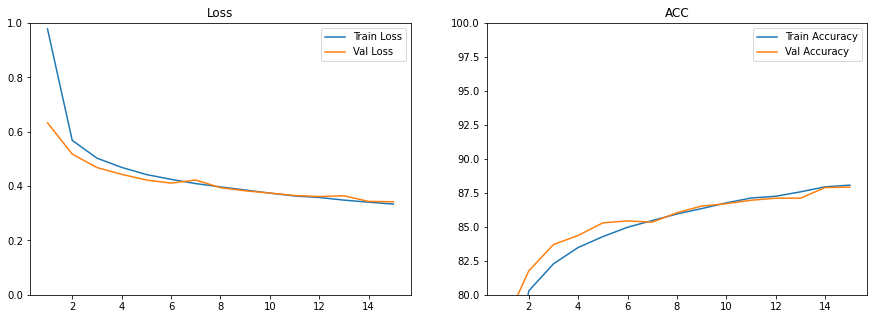

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [163]:
### kaiming_uniform 말고 xavier_uniform 사용해보았다

In [170]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [171]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [169]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.1454, 	Train Accuracy: 63.04 %, 	Val Loss: 0.6828, 	Val Accuracy: 75.94 % 

[EPOCH: 2], 	Train Loss: 0.6109, 	Train Accuracy: 79.18 %, 	Val Loss: 0.5408, 	Val Accuracy: 81.59 % 

[EPOCH: 3], 	Train Loss: 0.5221, 	Train Accuracy: 81.85 %, 	Val Loss: 0.4900, 	Val Accuracy: 82.66 % 

[EPOCH: 4], 	Train Loss: 0.4847, 	Train Accuracy: 83.04 %, 	Val Loss: 0.4668, 	Val Accuracy: 83.66 % 

[EPOCH: 5], 	Train Loss: 0.4596, 	Train Accuracy: 83.82 %, 	Val Loss: 0.4391, 	Val Accuracy: 84.54 % 

[EPOCH: 6], 	Train Loss: 0.4421, 	Train Accuracy: 84.35 %, 	Val Loss: 0.4844, 	Val Accuracy: 82.47 % 

[EPOCH: 7], 	Train Loss: 0.4283, 	Train Accuracy: 84.90 %, 	Val Loss: 0.4361, 	Val Accuracy: 84.90 % 

[EPOCH: 8], 	Train Loss: 0.4153, 	Train Accuracy: 85.30 %, 	Val Loss: 0.4905, 	Val Accuracy: 82.61 % 

[EPOCH: 9], 	Train Loss: 0.4031, 	Train Accuracy: 85.76 %, 	Val Loss: 0.4036, 	Val Accuracy: 85.59 % 

[EPOCH: 10], 	Train Loss: 0.3901, 	Train Accuracy: 86.09 %, 	Val Loss: 0.

## 변형 3 

### Batch Normalization

In [172]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [173]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [174]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.8148, 	Train Accuracy: 75.42 %, 	Val Loss: 0.5159, 	Val Accuracy: 82.32 % 

[EPOCH: 2], 	Train Loss: 0.4772, 	Train Accuracy: 83.38 %, 	Val Loss: 0.4213, 	Val Accuracy: 84.93 % 

[EPOCH: 3], 	Train Loss: 0.4080, 	Train Accuracy: 85.57 %, 	Val Loss: 0.3837, 	Val Accuracy: 86.31 % 

[EPOCH: 4], 	Train Loss: 0.3689, 	Train Accuracy: 86.87 %, 	Val Loss: 0.3590, 	Val Accuracy: 87.06 % 

[EPOCH: 5], 	Train Loss: 0.3434, 	Train Accuracy: 87.76 %, 	Val Loss: 0.3447, 	Val Accuracy: 87.82 % 

[EPOCH: 6], 	Train Loss: 0.3189, 	Train Accuracy: 88.62 %, 	Val Loss: 0.3432, 	Val Accuracy: 87.65 % 

[EPOCH: 7], 	Train Loss: 0.3024, 	Train Accuracy: 89.26 %, 	Val Loss: 0.3373, 	Val Accuracy: 87.60 % 

[EPOCH: 8], 	Train Loss: 0.2862, 	Train Accuracy: 89.72 %, 	Val Loss: 0.3309, 	Val Accuracy: 88.03 % 

[EPOCH: 9], 	Train Loss: 0.2691, 	Train Accuracy: 90.50 %, 	Val Loss: 0.3240, 	Val Accuracy: 88.23 % 

[EPOCH: 10], 	Train Loss: 0.2542, 	Train Accuracy: 91.03 %, 	Val Loss: 0.

### batchnorm을 해주니 성능이 향상되었다.

## 변형 4 
### Optimization SGD -> Adam

In [179]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [180]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [181]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.4846, 	Train Accuracy: 82.27 %, 	Val Loss: 0.4002, 	Val Accuracy: 85.01 % 

[EPOCH: 2], 	Train Loss: 0.3736, 	Train Accuracy: 86.13 %, 	Val Loss: 0.3907, 	Val Accuracy: 86.17 % 

[EPOCH: 3], 	Train Loss: 0.3285, 	Train Accuracy: 87.94 %, 	Val Loss: 0.3690, 	Val Accuracy: 85.88 % 

[EPOCH: 4], 	Train Loss: 0.3026, 	Train Accuracy: 88.66 %, 	Val Loss: 0.3361, 	Val Accuracy: 87.93 % 

[EPOCH: 5], 	Train Loss: 0.2809, 	Train Accuracy: 89.48 %, 	Val Loss: 0.3289, 	Val Accuracy: 87.92 % 

[EPOCH: 6], 	Train Loss: 0.2589, 	Train Accuracy: 90.25 %, 	Val Loss: 0.3025, 	Val Accuracy: 88.98 % 

[EPOCH: 7], 	Train Loss: 0.2488, 	Train Accuracy: 90.67 %, 	Val Loss: 0.2926, 	Val Accuracy: 89.60 % 

[EPOCH: 8], 	Train Loss: 0.2306, 	Train Accuracy: 91.34 %, 	Val Loss: 0.3170, 	Val Accuracy: 88.40 % 

[EPOCH: 9], 	Train Loss: 0.2194, 	Train Accuracy: 91.71 %, 	Val Loss: 0.2942, 	Val Accuracy: 89.57 % 

[EPOCH: 10], 	Train Loss: 0.2024, 	Train Accuracy: 92.18 %, 	Val Loss: 0.

### 성능이 살짝 .. ? 향상된 것 같다

## 변형 5

### Dropout

In [182]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [183]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [184]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5267, 	Train Accuracy: 81.04 %, 	Val Loss: 0.4145, 	Val Accuracy: 84.76 % 

[EPOCH: 2], 	Train Loss: 0.4131, 	Train Accuracy: 85.07 %, 	Val Loss: 0.3691, 	Val Accuracy: 86.14 % 

[EPOCH: 3], 	Train Loss: 0.3683, 	Train Accuracy: 86.67 %, 	Val Loss: 0.3417, 	Val Accuracy: 86.83 % 

[EPOCH: 4], 	Train Loss: 0.3458, 	Train Accuracy: 87.24 %, 	Val Loss: 0.3252, 	Val Accuracy: 87.76 % 

[EPOCH: 5], 	Train Loss: 0.3294, 	Train Accuracy: 87.93 %, 	Val Loss: 0.3056, 	Val Accuracy: 88.61 % 

[EPOCH: 6], 	Train Loss: 0.3087, 	Train Accuracy: 88.59 %, 	Val Loss: 0.3049, 	Val Accuracy: 89.02 % 

[EPOCH: 7], 	Train Loss: 0.2945, 	Train Accuracy: 89.08 %, 	Val Loss: 0.3008, 	Val Accuracy: 88.87 % 

[EPOCH: 8], 	Train Loss: 0.2868, 	Train Accuracy: 89.55 %, 	Val Loss: 0.3003, 	Val Accuracy: 89.03 % 

[EPOCH: 9], 	Train Loss: 0.2716, 	Train Accuracy: 89.75 %, 	Val Loss: 0.3061, 	Val Accuracy: 88.92 % 

[EPOCH: 10], 	Train Loss: 0.2664, 	Train Accuracy: 90.07 %, 	Val Loss: 0.

### dropout을 하니까 성능이 높아졌다

## 변형 6 
### Regularization

In [185]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [186]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [189]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5819, 	Train Accuracy: 79.69 %, 	Val Loss: 0.5506, 	Val Accuracy: 80.09 % 

[EPOCH: 2], 	Train Loss: 0.5824, 	Train Accuracy: 79.47 %, 	Val Loss: 0.6076, 	Val Accuracy: 78.70 % 

[EPOCH: 3], 	Train Loss: 0.5796, 	Train Accuracy: 79.72 %, 	Val Loss: 0.5349, 	Val Accuracy: 80.13 % 

[EPOCH: 4], 	Train Loss: 0.5777, 	Train Accuracy: 79.64 %, 	Val Loss: 0.5057, 	Val Accuracy: 81.82 % 

[EPOCH: 5], 	Train Loss: 0.5816, 	Train Accuracy: 79.79 %, 	Val Loss: 0.6053, 	Val Accuracy: 78.90 % 

[EPOCH: 6], 	Train Loss: 0.5813, 	Train Accuracy: 79.53 %, 	Val Loss: 0.5076, 	Val Accuracy: 81.56 % 

[EPOCH: 7], 	Train Loss: 0.5839, 	Train Accuracy: 79.46 %, 	Val Loss: 0.5388, 	Val Accuracy: 80.05 % 

[EPOCH: 8], 	Train Loss: 0.5783, 	Train Accuracy: 79.71 %, 	Val Loss: 0.5708, 	Val Accuracy: 79.26 % 

[EPOCH: 9], 	Train Loss: 0.5793, 	Train Accuracy: 79.74 %, 	Val Loss: 0.5154, 	Val Accuracy: 81.52 % 

[EPOCH: 10], 	Train Loss: 0.5808, 	Train Accuracy: 79.88 %, 	Val Loss: 0.

오히려 성능이 안 좋아졌다

### 변형 7 
### 이것저것 해보기

In [190]:
#1. epoch 수 늘려보기 15 -> 20
EPOCHS = 20

In [192]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.6346, 	Train Accuracy: 77.21 %, 	Val Loss: 0.6930, 	Val Accuracy: 74.29 % 

[EPOCH: 2], 	Train Loss: 0.6047, 	Train Accuracy: 78.59 %, 	Val Loss: 0.6372, 	Val Accuracy: 75.39 % 

[EPOCH: 3], 	Train Loss: 0.5942, 	Train Accuracy: 79.16 %, 	Val Loss: 0.5658, 	Val Accuracy: 79.81 % 

[EPOCH: 4], 	Train Loss: 0.5951, 	Train Accuracy: 79.23 %, 	Val Loss: 0.5133, 	Val Accuracy: 81.24 % 

[EPOCH: 5], 	Train Loss: 0.5917, 	Train Accuracy: 79.03 %, 	Val Loss: 0.5674, 	Val Accuracy: 78.15 % 

[EPOCH: 6], 	Train Loss: 0.5923, 	Train Accuracy: 79.15 %, 	Val Loss: 0.5511, 	Val Accuracy: 80.42 % 

[EPOCH: 7], 	Train Loss: 0.5882, 	Train Accuracy: 79.17 %, 	Val Loss: 0.5405, 	Val Accuracy: 80.59 % 

[EPOCH: 8], 	Train Loss: 0.5893, 	Train Accuracy: 79.18 %, 	Val Loss: 0.5338, 	Val Accuracy: 80.48 % 

[EPOCH: 9], 	Train Loss: 0.5831, 	Train Accuracy: 79.46 %, 	Val Loss: 0.6951, 	Val Accuracy: 70.64 % 

[EPOCH: 10], 	Train Loss: 0.5887, 	Train Accuracy: 79.38 %, 	Val Loss: 0.

EPOCHS = 15
dropout 0.25로 늘려보고
lr = 0.02로 바꿔보기

In [194]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.25)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.25)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.25)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.02, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [195]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.7272, 	Train Accuracy: 74.03 %, 	Val Loss: 0.8094, 	Val Accuracy: 70.97 % 

[EPOCH: 2], 	Train Loss: 0.7124, 	Train Accuracy: 74.95 %, 	Val Loss: 0.6721, 	Val Accuracy: 76.30 % 

[EPOCH: 3], 	Train Loss: 0.7185, 	Train Accuracy: 74.54 %, 	Val Loss: 0.6174, 	Val Accuracy: 78.52 % 

[EPOCH: 4], 	Train Loss: 0.7155, 	Train Accuracy: 74.97 %, 	Val Loss: 0.6491, 	Val Accuracy: 77.30 % 

[EPOCH: 5], 	Train Loss: 0.7250, 	Train Accuracy: 74.72 %, 	Val Loss: 1.0808, 	Val Accuracy: 63.35 % 

[EPOCH: 6], 	Train Loss: 0.7245, 	Train Accuracy: 74.52 %, 	Val Loss: 0.8194, 	Val Accuracy: 74.12 % 

[EPOCH: 7], 	Train Loss: 0.7117, 	Train Accuracy: 75.30 %, 	Val Loss: 0.6001, 	Val Accuracy: 80.59 % 

[EPOCH: 8], 	Train Loss: 0.7175, 	Train Accuracy: 74.92 %, 	Val Loss: 0.6489, 	Val Accuracy: 77.66 % 

[EPOCH: 9], 	Train Loss: 0.7147, 	Train Accuracy: 75.00 %, 	Val Loss: 0.8436, 	Val Accuracy: 74.26 % 

[EPOCH: 10], 	Train Loss: 0.7165, 	Train Accuracy: 75.05 %, 	Val Loss: 0.

성능이 더 안 좋아졌다 ...

## baseline_Model_TensorFlow

In [196]:
Train = pd.read_csv('Train.csv')
Test = pd.read_csv('Test.csv')

In [197]:
X = Train.iloc[:, :-1].values
X = X.reshape(-1, 28, 28, 1)
y = Train.iloc[:, -1].values

In [198]:
X_test = Test.values
X_test = X_test.reshape(-1, 28, 28, 1)

In [199]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

# 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [200]:
BATCH_SIZE = 128
EPOCHS = 15

In [201]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(512, activation='linear'),
    keras.layers.Dense(256, activation='linear'),
    keras.layers.Dense(128, activation='linear'),
    keras.layers.Dense(10, activation='softmax')
])

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               401920    
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dense_28 (Dense)            (None, 10)                1290      
                                                                 
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________
None


In [202]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.5)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [203]:
result = model.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val))

Epoch 1/10
1488/1488 [==============================] - 10s 6ms/step - loss: 0.5756 - accuracy: 0.7989 - val_loss: 0.4652 - val_accuracy: 0.8382
Epoch 2/10
1488/1488 [==============================] - 9s 6ms/step - loss: 0.4734 - accuracy: 0.8336 - val_loss: 0.4494 - val_accuracy: 0.8418
Epoch 3/10
1488/1488 [==============================] - 9s 6ms/step - loss: 0.4557 - accuracy: 0.8404 - val_loss: 0.4282 - val_accuracy: 0.8519
Epoch 4/10
1488/1488 [==============================] - 9s 6ms/step - loss: 0.4437 - accuracy: 0.8425 - val_loss: 0.4337 - val_accuracy: 0.8492
Epoch 5/10
1488/1488 [==============================] - 10s 6ms/step - loss: 0.4365 - accuracy: 0.8467 - val_loss: 0.4509 - val_accuracy: 0.8415
Epoch 6/10
1488/1488 [==============================] - 9s 6ms/step - loss: 0.4306 - accuracy: 0.8504 - val_loss: 0.4505 - val_accuracy: 0.8389
Epoch 7/10
1488/1488 [==============================] - 10s 6ms/step - loss: 0.4254 - accuracy: 0.8506 - val_loss: 0.4528 - val_accura

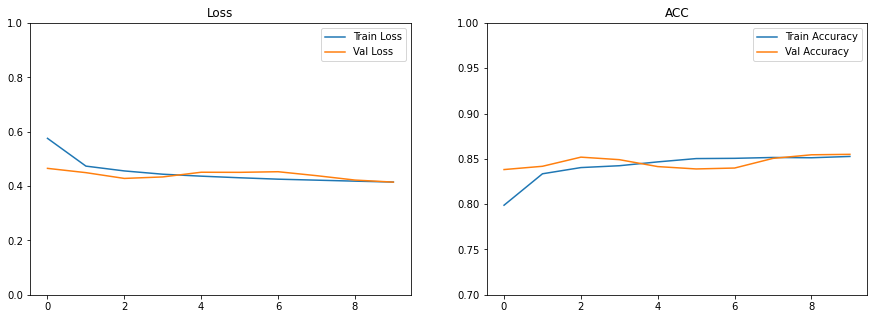

In [204]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result.epoch, result.history["loss"], label='Train Loss')
axes[0].plot(result.epoch, result.history['val_loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result.epoch, result.history['accuracy'], label='Train Accuracy')
axes[1].plot(result.epoch, result.history['val_accuracy'], label='Val Accuracy')
axes[1].set_ylim(0.7, 1)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 변형하기

In [214]:
input_shape = [128,1,28,28]
model = keras.Sequential([
    keras.layers.Conv2D(1,kernel_size=(3,3),padding='valid',activation='relu',input_shape=input_shape,data_format='channels_first'),
    keras.layers.Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'),
    keras.layers.Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='linear'),
    keras.layers.Dense(256, activation='linear'),
    keras.layers.Dense(10, activation='softmax')
])

print(model.summary())

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_37. Consider increasing the input size. Received input shape [None, 128, 1, 26, 26] which would produce output shape with a zero or negative value in a dimension.

conv2d를 적용하고 싶은데 에러가 납니다.. 나중에 수정할 수 있으면 수정하겠습니다!

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.5)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
result = model.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val))

In [210]:
X_train.shape

(47600, 28, 28, 1)

In [ ]:
#keras.layers.MaxPool2D(pool_size=(2, 2)),